In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as col
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, LogLocator
import scipy.stats
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm, LinearSegmentedColormap
import matplotlib.lines as mlines
from plotpack import *
%matplotlib inline

# font size and style
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 45}
legsize = 30
axsize  = 22
marksize   = 13
majticklen = 20
minticklen = 10
tickwidth  = 5
matplotlib.rc('font', **font)

c1 = ['black', 'tab:blue', 'darkred', 'darkgreen', 'darkred', 'dimgray']
colors = ["darkred","red","darkorange", "yellow", "darkgreen", "lightseagreen", "cornflowerblue", "darkblue"]
nodes = [0.0, 0.22, 0.44, 0.65,0.673,0.675,0.8, 1.0]
cmap1 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

/tmp/ipykernel_14721/3281432048.py:11: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [5]:
directory = './experiments/mass2fr/'
IGFt      = 1

In [6]:
var = ['tmin', 'mtot', 'z', 'vt','d','A' , 'm_i', 'V_i', 'phi', 'rho_app', 'mm', 'm_r', 'v_r', 'xi', 'rho_tot']

In [7]:
#file1  = directory+'1d_obl_xi5000_nz250_lwc3_ncl33_dtc5_nrp10_rm10_rt0_vt3_h6-12_ba500_habit1_ckt0_ssat5_agg0_domtop5000._nucl1_IGF'+str(IGFt)+'_novent_xi'
#file2  = directory+'1d_pro_xi5000_nz250_lwc3_ncl33_dtc5_nrp10_rm10_rt0_vt3_h10-20_ba500_habit1_ckt0_ssat5_agg0_domtop5000._nucl1_IGF'+str(IGFt)+'_novent_nointpro'
file1  = directory+'1d_obl_xi5000_nz250_lwc0_ncl33_dtc5_nrp10_rm10_rt0_vt3_h6-6_ba500_habit1_ckt0_ssat5_agg0_domtop5000._nucl1_IGF'+str(IGFt)+'_vent_xi'
file2  = directory+'1d_pro_xi5000_nz250_lwc0_ncl33_dtc5_nrp10_rm10_rt0_vt3_h10-10_ba500_habit1_ckt0_ssat5_agg0_domtop5000._nucl1_IGF'+str(IGFt)+'_vent_intpro'
file3  = directory+'mass2fr'

post = ''#'_noLWC'

df_obl = pd.read_csv(file1+'.dat', delimiter = ",", names=var, header=1)
df_pro = pd.read_csv(file2+'.dat', delimiter = ",", names=var, header=1)
df_mD  = pd.read_csv(file3+'.dat', delimiter = ",", names=var, header=1)

rhoi = 917.
df_obl['A'] = df_obl['A'] / ( (1. - df_obl['phi']) * (df_obl['rho_app'] / rhoi) + df_obl['phi'] )

In [8]:


m_star_obl = df_obl['mtot'] / (rhoi * 4./3. * np.pi * (df_obl['d']/2)**3 )
m_star_pro = df_pro['mtot'] / (rhoi * 4./3. * np.pi * (df_pro['d']/2)**3 )

m_star_mD = df_mD['mtot'] / (rhoi * 4./3. * np.pi * (df_mD['d']/2)**3 )


In [9]:
unr_bet = 2.1
unr_alf = 0.0028*10**(2.*unr_bet-3.)
unr_gam = 1.88                         
unr_sig = 0.2285*10**(2.*unr_gam-4.)
sph_sig = np.pi/4.0

m_i = np.logspace(-12,-3,500)
dice = np.zeros(len(m_i))
aice = np.zeros(len(m_i))
dunr = np.zeros(len(m_i))
aunr = np.zeros(len(m_i))

unr_bet_i = 1. / unr_bet
unr_alf_i = 1. / unr_alf
rhoii     = 1. / rhoi
sph_gam   = 2.0
betm3       = unr_bet - 3.     
betm3_i     = 1. / betm3

Dth         = (rhoi * np.pi / 6. * unr_alf_i)**betm3_i
mth         = np.pi / 6. * rhoi * Dth**3

for i in range(len(m_i)):
    dice[i] = (6./np.pi * m_i[i] * rhoii)**(1./3.)
    aice[i] = sph_sig * dice[i]**sph_gam
    if( m_i[i] < mth):
        dunr[i] = dice[i]
        aunr[i] = aice[i]
    else:
        dunr[i] = (m_i[i] * unr_alf_i)**unr_bet_i
        aunr[i] = unr_sig * dunr[i]**unr_gam 
        aunr[i] = max(aunr[i],aice[i])

    
m_star = m_i / (rhoi * 4./3. * np.pi * (dunr/2)**3 )

In [10]:
rho   = 1.045               # @ z = 2000m 
eta   = 1.653e-5            # @ z = 2000m
grav  = 9.81

Ar = aunr * 4./np.pi
Xbest = rho * 8. * m_i * grav * dunr / (eta**2 * np.pi * np.sqrt(aunr))

do_i = 8.0
co_i = 0.35
c_1 = 4.0 / ( do_i**2 * np.sqrt(co_i) )
c_2 = 0.25 * do_i**2
bracket = np.sqrt(1.0 + c_1 * np.sqrt(Xbest)) - 1.0
Re = c_2 * bracket**2

vt_hw = eta * Re / (rho * dunr)

In [11]:
Vb = m_i*rhoii
Fb = rho * Vb * grav
Xbest2 = 2. * np.absolute(m_i*grav-Fb) * rho * dice**2 / (aunr * eta**2)

do_i2 = 5.83
co_i2 = 0.6
Ct    = 1.6
X0_i  = 0.35714285714285714285e-6 
c_11  = 4.0 / ( do_i2**2 * np.sqrt(co_i2) )
c_21  = 0.25 * do_i2**2


bracket2 = np.sqrt(1.0 + c_11 * np.sqrt(Xbest2)) - 1.0
psi = (1. + (Xbest2 * X0_i)**2) / (1 + Ct * (Xbest2 * X0_i)**2)
Re  = c_21 * bracket2**2 
Cd = co_i2 * (1. + do_i2 / np.sqrt(Re))**2 / psi

vt_kc = np.sqrt( 2. * np.absolute(m_i*grav - Fb)/(rho * aunr * Cd) )

In [12]:
X_0 = 2.8e6

vterm_bohm = np.zeros(len(aunr))

for j in range(len(aunr)):
    q = aunr[j] / (np.pi/4. * dunr[j]**2)
    phi = 1.
    k = min(max(0.82 + 0.18 * phi, 0.85),0.37 + 0.63 / phi, 1.33 / (max(np.log(phi),0.0) + 1.19))

    gama_big = max(1.0, min(1.98,3.76 - 8.41 * phi + 9.18 * phi**2 - 3.53*phi**3))
    C_DP = max(0.292 * k * gama_big, 0.492 - 0.2 / np.sqrt(phi))
    C_DP = max(1.0, q * (1.46 * q - 0.46)) * C_DP

    X = 8.0 * m_i[j] * grav * rho / (np.pi * (eta**2) * max(phi,1.0) * max(q**(1.0/4.0),q))

    C_DP_prim = C_DP * ((1.0 + 1.6 * (X/X_0)**2) / (1.0 + (X/X_0)**2))

    beta = np.sqrt(1.0 + C_DP_prim / 6.0 / k * np.sqrt(X / C_DP_prim)) - 1

    N_Re0 = 6.0 * k / C_DP_prim * beta**2

    C_DO = 4.5 * k**2 * max(phi,1.0)
    gama_small = (C_DO - C_DP) / (4.0 * C_DP)

    N_Re  = N_Re0 * (1.0 + (2.0 * beta * np.exp(-beta * gama_small)) / ((2.0 + beta) * (1.0 + beta)) )

    vterm_bohm[j] = N_Re * eta / (dunr[j] * rho)      

In [13]:
# Formulations of Heymsfield 72


#
def heyms_vel(F,X,G,B,C,H,DELTAS):
    return F * (10**(G + B * np.log(X) + C * (np.log(X))**2 + H * (np.log(X))**3) + DELTAS)
# Columns
def heyms_col(L):
    t      = -19.
    p      = 287. * (273 + t)
    rho_a_cgs = p / (287. * (273. + t) ) / 1000.
    eta_h  = 4301e-2 / p * (t + 273.)**(5./2.) / (t + 393.)
    L     = L * 1e3
        
    if (L >= 0.028):
        rho_s = 0.65 * L**(-0.0915)
    else:
        rho_s = 0.9
        
    if (L <= 0.2):
        F = 20. * eta_h / L
        X = 1.59e-1 * L**3 * rho_s / (eta_h**2 * rho_a_cgs)
        wL   = 0.5 * L
    else:
        F = eta_h / (1.973e-2 * L**(0.414))
        X = 9.78e-3 * L**(1.242) * rho_s / (eta_h**2 * rho_a_cgs)
        wL   = 0.1973 * L**(-0.586)
    G = -1.10114
    B = 1.05687
    C = -0.09244
    H = 0.00535
    logx = np.log(X)
    DELTAS = 10**(-0.90186 + 1.0034 * logx - 0.10142 * logx**2 + 0.0083 * logx**3 ) - 10**(-1.10114 + 1.05687 * logx - 0.09244 * logx**2 + 0.00535 * logx**3) * (-2.56 * (wL)**(0.5) + 1.81)  
    return heyms_vel(F,X,G,B,C,H,DELTAS) / 100.

def heyms_needle(L):
    t      = -5.
    p      = 287. * (273 + t)
    rho_a_cgs = p / (287. * (273. + t) ) / 1000.
    eta_h  = 4301e-2 / p * (t + 273.)**(5./2.) / (t + 393.)
    L     = L * 1e3
    if (L >= 0.031):
        rho_s = 0.6 * L**(-0.117)
    else:
        rho_s = 0.9
    F = eta_h / (7.467e-3 * L**(0.61078))
    X = 5.3e-4 * L**(1.832) * rho_s / (eta_h**2 * rho_a_cgs)
    G = -0.90186
    B = 1.00341
    C = -0.10142
    H = 0.00831
    DELTAS = 0.
    return heyms_vel(F,X,G,B,C,H,DELTAS) / 100.

def heyms_plate(D):
    t      = -11.
    p      = 287. * (273 + t)
    rho_a_cgs = p / (287. * (273. + t) ) / 1000.
    eta_h  = 4301e-2 / p * (t + 273.)**(5./2.) / (t + 393.)
    D     = D * 1e3
    rho_s = 0.9
    L = 2.801 * (D*1e3)**0.377 * 1e-3
    F = 10. * eta_h / D 
    X = 9.12e-2 * L**(2.449) * rho_s / (eta_h**2 * rho_a_cgs)
    G = -1.17758
    B = 0.84874
    C = 0.02248
    H = -0.00998
    DELTAS = 0.
    return heyms_vel(F,X,G,B,C,H,DELTAS) / 100.

def heyms_denvel(D):
    t      = -15.
    p      = 287. * (273 + t)
    rho_a_cgs = p / (287. * (273. + t) ) / 1000.
    eta_h  = 4301e-2 / p * (t + 273.)**(5./2.) / (t + 393.)
    D = D * 1e3
    if (D >= 0.3):
        rho_d = 0.588 * (D)**(-0.377)
    else:
        rho_d = .9
    return 0.2587 * D**(0.55) / eta_h**(0.304) * (rho_d/rho_a_cgs)**(0.652) / 100.

#F,X,G,B,C,H,DELTAS = heyms_plate(1e-3, -10)
#U = heyms_vel(F,X,G,B,C,H,DELTAS) / 100.

u_heykaj_plate = 41.9 * m_i**(0.26)
D_heykaj_plate = 0.22 * m_i**(1. / 3.31)

u_heykaj_dend = 11.0 * m_i**(0.21)
D_heykaj_dend = 5.17 * m_i**(1. / 2.29)

u_pk_col   = 2.53 * m_i**(0.271)
D_pk_col   = (m_i * 1000 / 0.037)**(1./1.8) * 1e-3

U_col  = np.zeros(len(dice))
U_need = np.zeros(len(dice))
U_den  = np.zeros(len(dice))
U_pla  = np.zeros(len(dice))

for di in range(len(dice)):
    U_col[di]  = heyms_col(dice[di])
    U_need[di] = heyms_needle(dice[di])
    U_den[di]  = heyms_denvel(dice[di])
    #U_pla[di]  =  #heyms_plate(dice[di])
#print(U_pla)


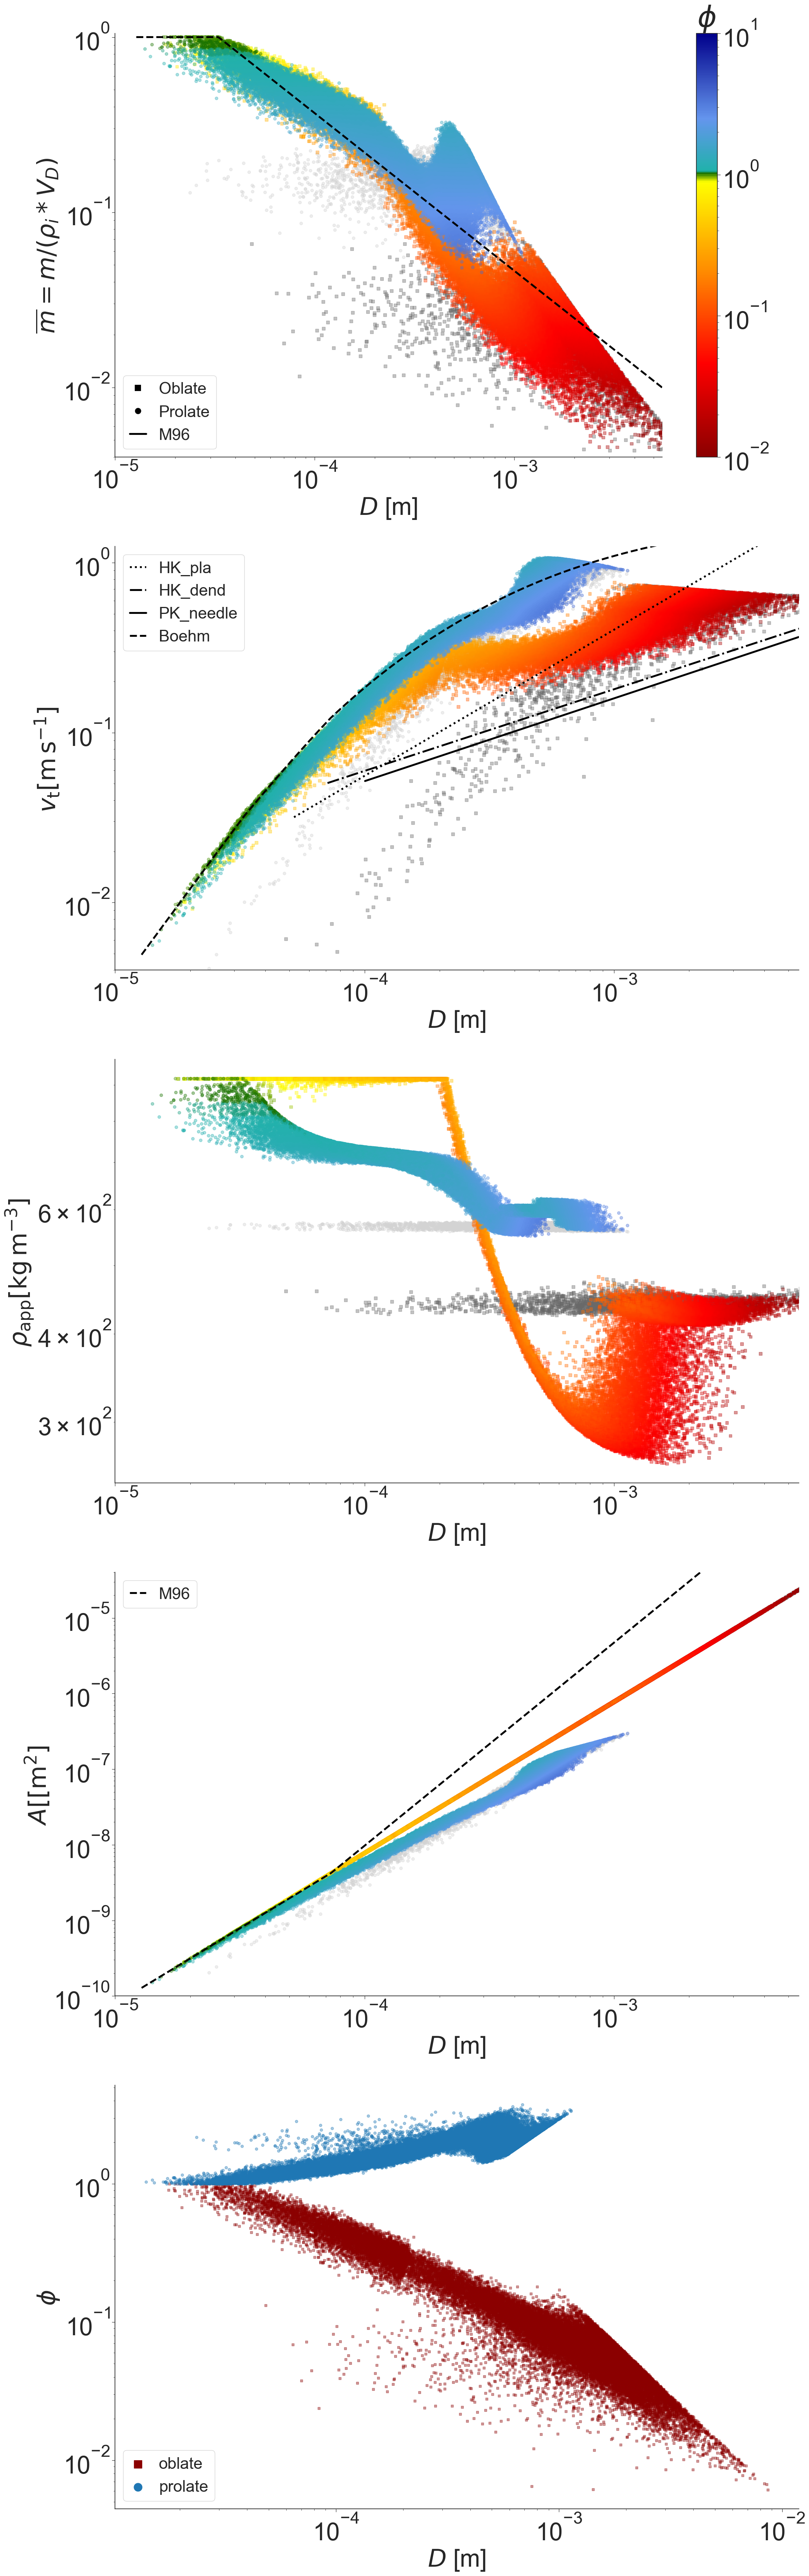

In [30]:
pp   = PdfPages('./PDFs/m2d_plots_IGF'+str(IGFt)+'_vent'+post+'.pdf')
row, col = [5,1]
fig = plt.figure(figsize=(22*col,15*row))

subl_z = [535.,890.]


ax1 = plt.subplot(row, col, 1)
ax1.set_xlabel('$D$ [m]')
ax1.set_ylabel('$\overline{m} = m / (\\rho_i * V_D)$')

ax1.set_xlim(1e-5,5.5e-3)
ax1.set_ylim(4e-3,1.05)
ax1.set_xscale('log')
ax1.set_yscale('log')
crit_obl = df_obl['z'] > subl_z[0]
crit_pro = df_pro['z'] > subl_z[1]
a1=ax1.scatter(df_obl['d'][np.invert(crit_obl)], m_star_obl[np.invert(crit_obl)], s=30, alpha=0.4, c='dimgray',  marker='s')
a1=ax1.scatter(df_pro['d'][np.invert(crit_pro)],m_star_pro[np.invert(crit_pro)], s=30,  alpha=0.4, c='lightgray', marker='o')
a1=ax1.scatter(df_obl['d'][crit_obl], m_star_obl[crit_obl], s=30, alpha=0.4, c=df_obl['phi'][crit_obl], cmap=cmap1, norm=LogNorm(0.01,10), marker='s')
a1=ax1.scatter(df_pro['d'][crit_pro],m_star_pro[crit_pro], s=30,  alpha=0.4,c=df_pro['phi'][crit_pro], cmap=cmap1, norm=LogNorm(0.01,10), marker='o')
#a1=ax1.scatter(df_mD['d'], m_star_mD, s=30, alpha=0.4, c='magenta',  marker='s')
#ax1.scatter(df_mD['d'][df_mD['z']>1000],m_star_mD[df_mD['z']>1000], alpha=0.4,c='black')
ax1.plot(dunr,m_star, color='black', label='M96', linestyle='--')
ax1.tick_params(axis='both', which='major', length=majticklen, width=tickwidth, color='black')
ax1.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth, color='black')

obl_square = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                          markersize=10, label='Oblate')
pro_circ = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=10, label='Prolate')
mich = mlines.Line2D([], [], color='black', marker='None', linestyle='solid',
                           label='M96')


leg = ax1.legend(handles=[obl_square, pro_circ,mich],fontsize = legsize,loc='lower left', ncol=1,columnspacing = 1, handlelength=1., frameon=True)

cbar = plt.colorbar(a1, alpha=1., cmap=cmap1)
cbar.ax.set_title("$\phi$")
cbar.solids.set_alpha(1.)


ax3 = plt.subplot(row, col, 2)
ax3.set_xlabel('$D$ [m]')
ax3.set_ylabel('$v_\mathrm{t}\mathrm{[m\,s}^{-1}]$ ')
ax3.set_xlim(1e-5,5.5e-3)
ax3.set_ylim(4e-3,1.25)
ax3.set_xscale('log')
ax3.set_yscale('log')
a3=ax3.scatter(df_obl['d'][np.invert(crit_obl)], df_obl['vt'][np.invert(crit_obl)], s=30, alpha=0.4, c='dimgray',  marker='s')
a3=ax3.scatter(df_pro['d'][np.invert(crit_pro)],df_pro['vt'][np.invert(crit_pro)], s=30,  alpha=0.4, c='lightgray', marker='o')
a3=ax3.scatter(df_obl['d'][crit_obl], df_obl['vt'][crit_obl], s=30, alpha=0.4, c=df_obl['phi'][crit_obl], cmap=cmap1, norm=LogNorm(0.01,10), marker='s')
a3=ax3.scatter(df_pro['d'][crit_pro],df_pro['vt'][crit_pro], s=30,  alpha=0.4,c=df_pro['phi'][crit_pro], cmap=cmap1, norm=LogNorm(0.01,10), marker='o')

ax3.tick_params(axis='both', which='major', length=majticklen, width=tickwidth, color='black')
ax3.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth, color='black')

crit_plate = (D_heykaj_plate >= 0.02e-3) & (D_heykaj_plate <= 7e-3)
crit_dend  = (D_heykaj_dend  >= 0.07e-3) & (D_heykaj_dend  <= 10.8e-3)
crit_col = (D_pk_col >= 0.1e-3)    & (D_pk_col <= 2.7e-2)
ax3.plot(D_heykaj_plate[crit_plate], u_heykaj_plate[crit_plate], color='black', linestyle='dotted', label='HK_pla')
ax3.plot(D_heykaj_dend[crit_dend],   u_heykaj_dend[crit_dend],   color='black', linestyle='dashdot', label='HK_dend')
ax3.plot(D_pk_col[crit_col],   u_pk_col[crit_col],   color='black', linestyle='solid', label='PK_needle')
ax3.plot(dice, vterm_bohm, color='black', linestyle='--', label='Boehm')
#ax3.plot(dice, U_col, color='black', linestyle='dotted', label='H72_col')
#ax3.plot(dice, U_den, color='black', linestyle='dashdot', label='H72_dend')
#ax3.plot(dice, U_need, color='black', linestyle='solid', label='H72_needle')
#ax3.plot(dice, U_pla, color='black', linestyle='solid', label='H72_plate', marker='H')
#ax1.scatter(df_mD['d'][df_mD['z']>1000],m_star_mD[df_mD['z']>1000], alpha=0.4,c='black')
leg3 = ax3.legend(fontsize = legsize,loc='upper left', ncol=1,columnspacing = 1, handlelength=1., frameon=True, markerscale=3)
for lh in leg3.legendHandles: 
    lh.set_alpha(1)

ax4 = plt.subplot(row, col, 3)
ax4.set_xlabel('$D$ [m]')
ax4.set_ylabel('$\\rho_\mathrm{app}\mathrm{[kg\,m}^{-3}]$ ')
ax4.set_xlim(1e-5,5.5e-3)
#ax4.set_ylim(1e2,1e3)
ax4.set_xscale('log')
ax4.set_yscale('log')
a4=ax4.scatter(df_obl['d'][np.invert(crit_obl)], df_obl['rho_app'][np.invert(crit_obl)], s=30, alpha=0.4, c='dimgray',  marker='s')
a4=ax4.scatter(df_pro['d'][np.invert(crit_pro)],df_pro['rho_app'][np.invert(crit_pro)], s=30,  alpha=0.4, c='lightgray', marker='o')
a4=ax4.scatter(df_obl['d'][crit_obl], df_obl['rho_app'][crit_obl], s=30, alpha=0.4, c=df_obl['phi'][crit_obl], cmap=cmap1, norm=LogNorm(0.01,10), marker='s')
a4=ax4.scatter(df_pro['d'][crit_pro],df_pro['rho_app'][crit_pro], s=30,  alpha=0.4,c=df_pro['phi'][crit_pro], cmap=cmap1, norm=LogNorm(0.01,10), marker='o')
ax4.tick_params(axis='both', which='major', length=majticklen, width=tickwidth, color='black')
ax4.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth, color='black')
#ax1.scatter(df_mD['d'][df_mD['z']>1000],m_star_mD[df_mD['z']>1000], alpha=0.4,c='black')
#leg4 = ax4.legend(fontsize = legsize,loc='lower left', ncol=1,columnspacing = 1, handlelength=1., frameon=True, markerscale=3)
#for lh in leg4.legendHandles: 
#    lh.set_alpha(1)

axt = plt.subplot(row, col, 4)
axt.set_xlabel('$D$ [m]')
axt.set_ylabel('$A [\mathrm{[m}^{2}]$ ')
axt.set_xlim(1e-5,5.5e-3)
axt.set_ylim(1e-10,4e-5)
axt.set_xscale('log')
axt.set_yscale('log')
at=axt.scatter(df_obl['d'][np.invert(crit_obl)], df_obl['A'][np.invert(crit_obl)], s=30, alpha=0.4, c='dimgray',  marker='s')
at=axt.scatter(df_pro['d'][np.invert(crit_pro)],df_pro['A'][np.invert(crit_pro)], s=30,  alpha=0.4, c='lightgray', marker='o')
at=axt.scatter(df_obl['d'][crit_obl], df_obl['A'][crit_obl], s=30, alpha=0.4, c=df_obl['phi'][crit_obl], cmap=cmap1, norm=LogNorm(0.01,10), marker='s')
at=axt.scatter(df_pro['d'][crit_pro],df_pro['A'][crit_pro], s=30,  alpha=0.4,c=df_pro['phi'][crit_pro], cmap=cmap1, norm=LogNorm(0.01,10), marker='o')
#ax3.plot(dice, vt_hw, color='black', label='HW10')
#ax3.plot(dice, vt_kc, color='black', linestyle='-.', label='KC05')
axt.plot(dice, aunr, color='black', linestyle='--', label='M96')
axt.tick_params(axis='both', which='major', length=majticklen, width=tickwidth, color='black')
axt.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth, color='black')
#ax1.scatter(df_mD['d'][df_mD['z']>1000],m_star_mD[df_mD['z']>1000], alpha=0.4,c='black')
legt = axt.legend(fontsize = legsize,loc='upper left', ncol=1,columnspacing = 1, handlelength=1., frameon=True, markerscale=3)
for lh in legt.legendHandles: 
    lh.set_alpha(1)

ax2 = plt.subplot(row, col, 5)
ax2.set_xlabel('$D$ [m]')
ax2.set_ylabel('$\phi$')
#ax1.set_ylabel('$N_\mathrm{Re}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.scatter(df_obl['d'],df_obl['phi'],label='oblate', alpha=0.4, c=c1[2], marker='s')
ax2.scatter(df_pro['d'],df_pro['phi'],label='prolate', alpha=0.4, c=c1[1], marker='o')

ax2.tick_params(axis='both', which='major', length=majticklen, width=tickwidth, color='black')
ax2.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth, color='black')

leg2 = ax2.legend(fontsize = legsize,loc='lower left', ncol=1,columnspacing = 1, handlelength=1., frameon=True, markerscale=3)
for lh in leg2.legendHandles: 
    lh.set_alpha(1)
    
plt.tight_layout(rect=[0, 0.0, 1, 0.9])

pp.savefig(bbox_inches = 'tight', pad_inches = 0.5)
fig.savefig('./PDFs/m2d_plots_IGF'+str(IGFt)+'_vent'+post+'.png')
pp.close()
    
    

In [14]:
import matplotlib.ticker as mtick
colors = ["darkred","red","darkorange", "yellow", "darkgreen", "lightseagreen", "cornflowerblue", "darkblue","midnightblue"]
nodes = [0.0, 0.17, 0.34, 0.485,0.505,0.51,0.66, 0.83, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

directory = './experiments/mass2fr/'
atmo_var = ['z', 'rho', 'T', 'p', 'eta', 'ssat', 'rh', 'psatw', 'psati', 'lwc', 'qv','IGF']
atmo = pd.read_csv(directory+'atmo.dat', delimiter = "   ", names=atmo_var, engine='python')

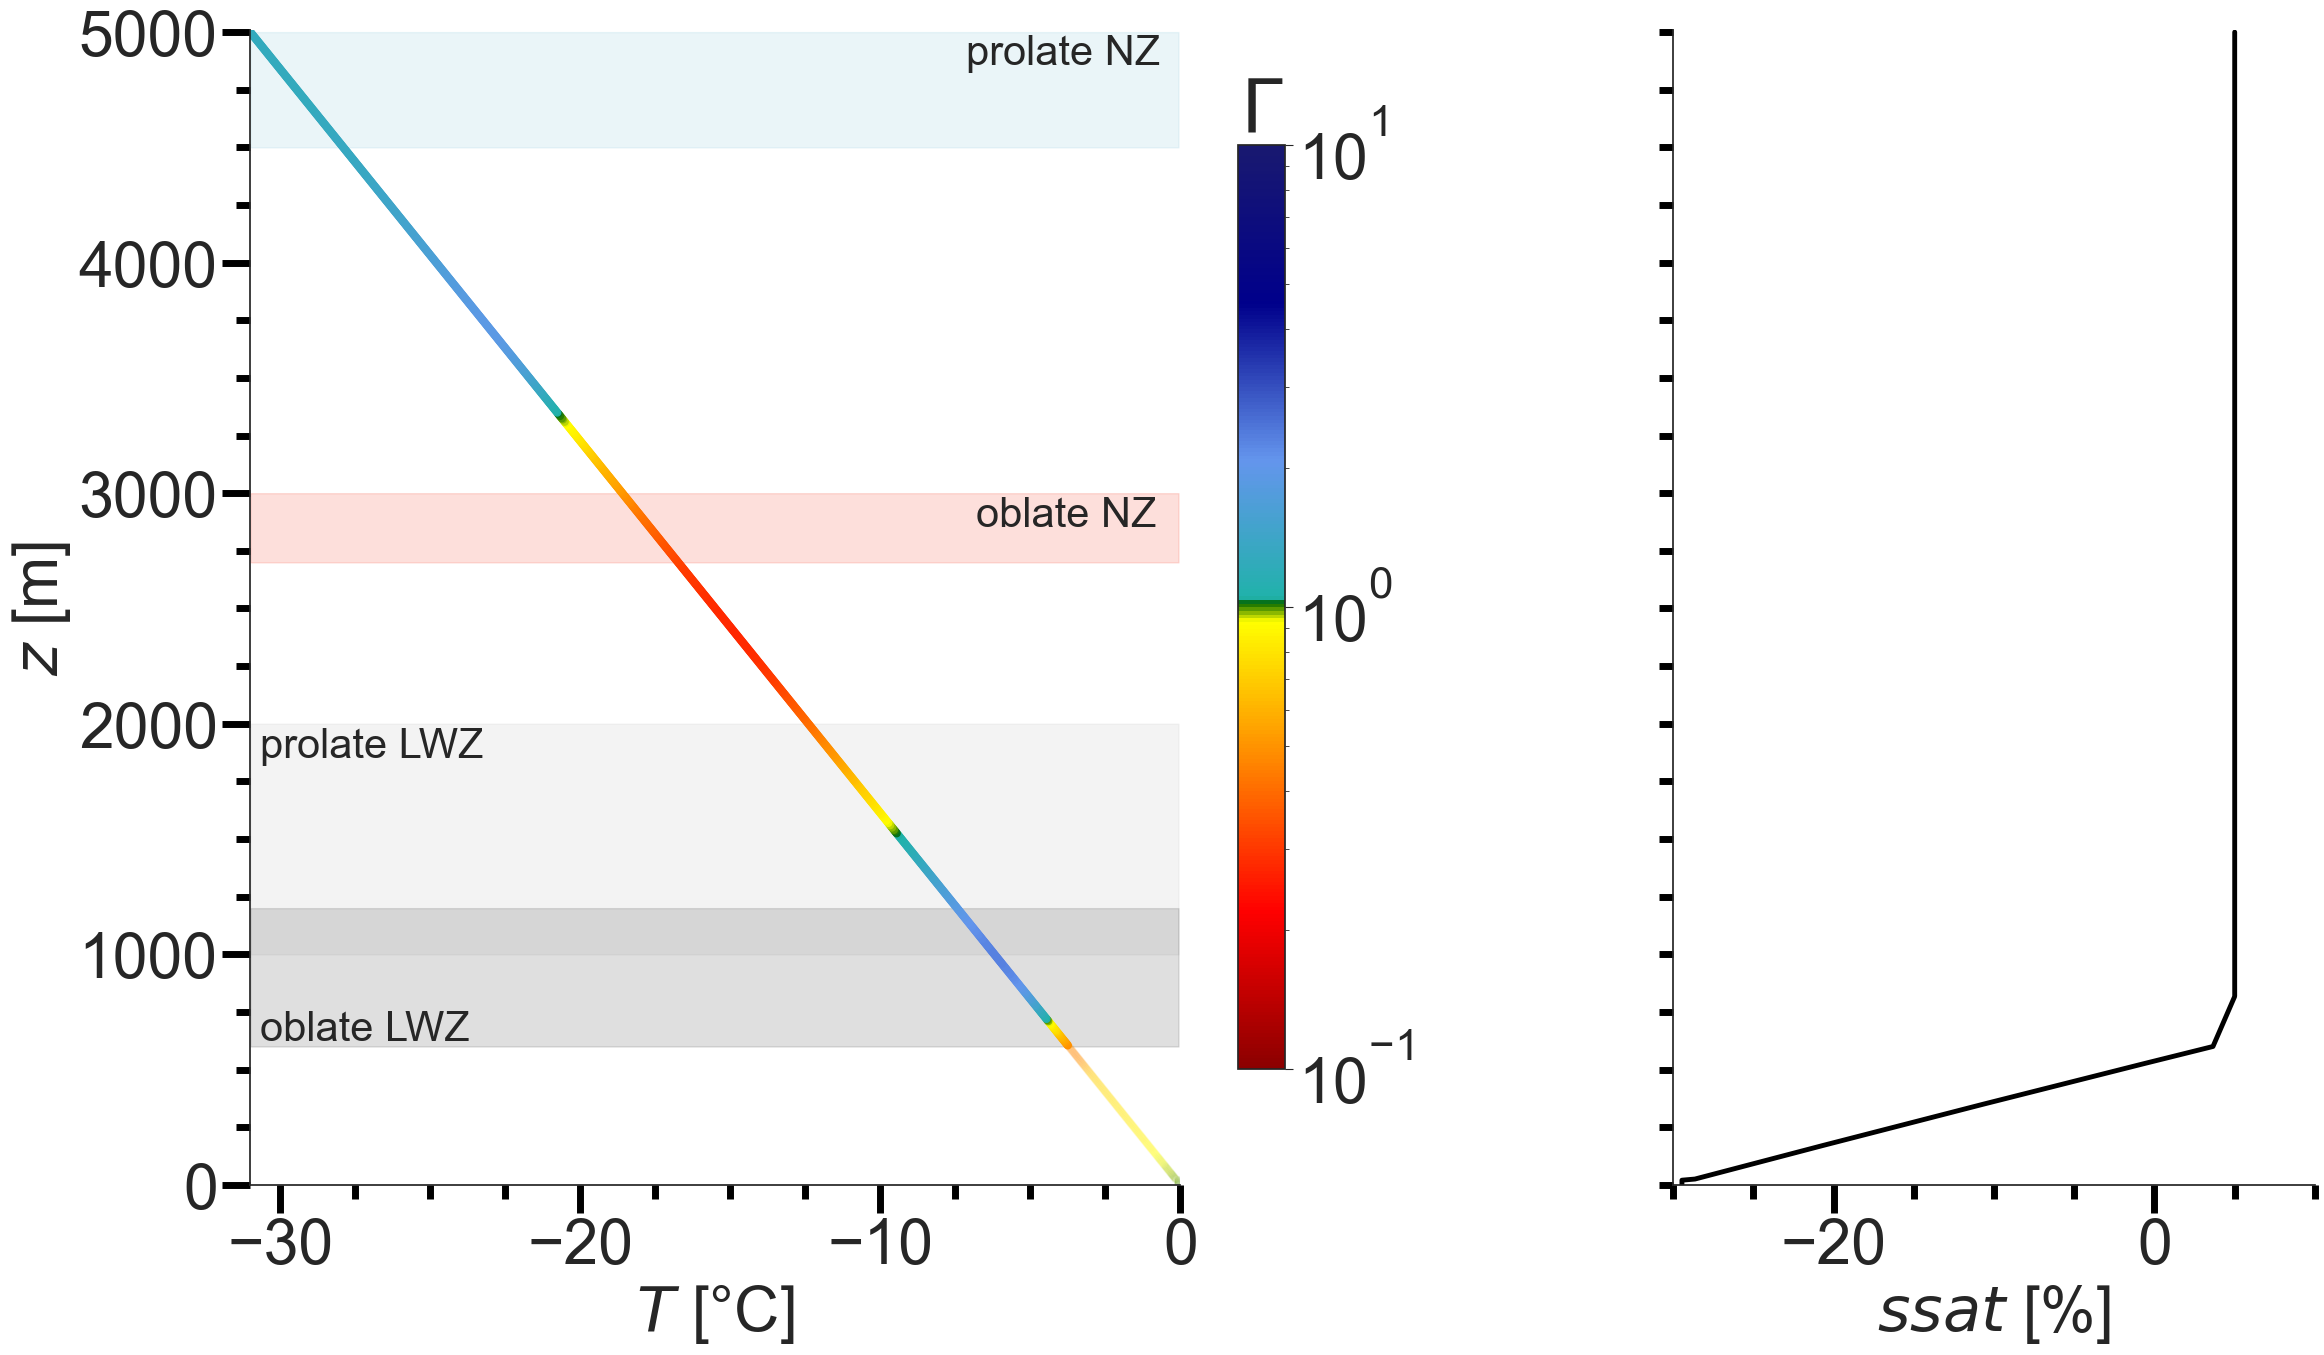

In [95]:
from matplotlib import gridspec
col, row = [2,1]
fig = plt.figure(figsize=(15*col,15*row))

gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.0, hspace=0.0)

ax1 = plt.subplot(gs1[0])
ax1.set_xlabel('$T$ [°C]')
ax1.set_ylabel('$z$ [m]')
ax1.tick_params(axis='both', which='major', length=majticklen, width=tickwidth, color='black')
ax1.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth, color='black')
ax1.xaxis.set_minor_locator(MultipleLocator(base = 2.5))
ax1.yaxis.set_minor_locator(MultipleLocator(base = 250))

ax1.set_xlim(np.amin(atmo['T'])-273.15,0)
ax1.set_ylim(0,5010.)
#ax1.set_xscale('log')
#ax1.set_yscale('log')
plt.fill_between(atmo['T']-273.15, 4500, 5000, color='lightblue', alpha=0.25)
plt.fill_between(atmo['T']-273.15, 2700, 3000, color='salmon', alpha=0.25)
plt.fill_between(atmo['T']-273.15, 1000, 2000, color='lightgray', alpha=0.25)
plt.fill_between(atmo['T']-273.15, 600, 1200, color='gray', alpha=0.25)
prof = ax1.scatter(atmo['T'][atmo['z']>600.]-273.15,atmo['z'][atmo['z']>600.],c=atmo['IGF'][atmo['z']>600.], cmap=cmap2, norm=LogNorm(0.1,10))
prof = ax1.scatter(atmo['T'][atmo['z']<=600.]-273.15,atmo['z'][atmo['z']<=600.],c=atmo['IGF'][atmo['z']<=600.], alpha=0.1, cmap=cmap2, norm=LogNorm(0.1,10))
cbar = plt.colorbar(prof, alpha=1., cmap=cmap1, shrink=0.8)
ax1.annotate('prolate NZ', xy=(0.77, 0.97), xycoords="axes fraction", fontsize=30)
ax1.annotate('oblate NZ', xy=(0.78, 0.57), xycoords="axes fraction", fontsize=30)
ax1.annotate('oblate LWZ', xy=(0.01, 0.125), xycoords="axes fraction", fontsize=30)
ax1.annotate('prolate LWZ', xy=(0.01, 0.37), xycoords="axes fraction", fontsize=30)

cbar.ax.set_title("$\Gamma$")
cbar.solids.set_alpha(1.)

ax2 = plt.subplot(gs1[1])

ax2.set_box_aspect(1.8)
ax2.set_xlabel('$ssat$ [%]')
ax2.set_ylabel('')
plt.yticks([])
ax2.tick_params(axis='both', which='major', length=majticklen, width=tickwidth, color='black')
ax2.tick_params(axis='both', which='minor', length=minticklen, width=tickwidth, color='black')
ax2.xaxis.set_minor_locator(MultipleLocator(base = 5))
ax2.yaxis.set_minor_locator(MultipleLocator(base = 250))

ax2.set_xlim(-30,10)
ax2.set_ylim(0,5010.)
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax2.plot(atmo['ssat']*100,atmo['z'],c='black')

